In [3]:
model = None
import os
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import pyaudio
import threading
import queue
import time
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Configuration (same as before)
SUBESCO_PATH = "H:\\SUBESCO"
BANGLASER_PATH = "H:\\BanglaSER"
BANSPEMO_PATH = "H:\\BANSpEmo A Bangla Language Emotional Speech Recognition Dataset\\BANSpEmo A Bangla Language Emotional Speech Recognition Dataset\\BANSpEmo Dataset"
MODEL_PATH = "bangla_emotion_model.pth"
EMOTIONS = ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]
SAMPLE_RATE = 16000
DURATION = 3
N_MFCC = 40
CHUNK_SIZE = 1024
FORMAT = pyaudio.paFloat32
CHANNELS = 1
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 50

# Emotion mappings (same as before)
SUBESCO_EMOTIONS = {
    "ANGRY": "Angry", "DISGUST": "Disgust", "FEAR": "Fear",
    "HAPPY": "Happy", "NEUTRAL": "Neutral", "SAD": "Sad", "SURPRISE": "Surprise"
}

BANGLASER_EMOTIONS = {
    "01": "Happy", "02": "Sad", "03": "Angry", "04": "Surprise", "05": "Neutral"
}

BANSPEMO_EMOTIONS = {
    "01": "Angry", "02": "Disgust", "03": "Fear", "04": "Happy", "05": "Sad", "06": "Surprise"
}

# Feature extraction and dataset loading (same as before)
def extract_features(file_path):
    try:
        audio, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=N_MFCC)
        return mfcc.T
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

def get_subesco_emotion(filename):
    parts = filename.split('_')
    return SUBESCO_EMOTIONS.get(parts[5], None) if len(parts) >= 5 else None

def get_banglaser_emotion(filename):
    parts = filename.split('-')
    return BANGLASER_EMOTIONS.get(parts[2], None) if len(parts) >= 3 else None

def get_banspemo_emotion(filename):
    parts = filename.split('_')
    return BANSPEMO_EMOTIONS.get(parts[-1].split('.')[0], None) if len(parts) >= 1 else None

class EmotionDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

class EmotionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(EmotionModel, self).__init__()
        self.conv1 = nn.Conv1d(input_size, 64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(2)
        self.dropout1 = nn.Dropout(0.3)
        
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(2)
        self.dropout2 = nn.Dropout(0.3)
        
        self.lstm1 = nn.LSTM(128, hidden_size, num_layers, batch_first=True, dropout=0.3, bidirectional=True)
        self.lstm2 = nn.LSTM(hidden_size*2, hidden_size, num_layers, batch_first=True, dropout=0.3, bidirectional=True)
        
        self.fc1 = nn.Linear(hidden_size*2, 64)
        self.fc2 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()
        self.dropout3 = nn.Dropout(0.3)
        
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        
        x = x.permute(0, 2, 1)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout3(x)
        x = self.fc2(x)
        return x

def load_data():
    features = []
    labels = []

    print("Processing SUBESCO dataset...")
    for root, _, files in os.walk(SUBESCO_PATH):
        for filename in files:
            if filename.endswith('.wav'):
                emotion = get_subesco_emotion(filename)
                if emotion:
                    file_path = os.path.join(root, filename)
                    mfcc = extract_features(file_path)
                    if mfcc is not None:
                        features.append(mfcc)
                        labels.append(emotion)

    print("Processing BANSPEMO dataset...")
    for root, _, files in os.walk(BANSPEMO_PATH):
        for filename in files:
            if filename.endswith('.wav'):
                emotion = get_banspemo_emotion(filename)
                if emotion:
                    file_path = os.path.join(root, filename)
                    mfcc = extract_features(file_path)
                    if mfcc is not None:
                        features.append(mfcc)
                        labels.append(emotion)

    print("Processing BANGLASER dataset...")
    for actor_folder in os.listdir(BANGLASER_PATH):
        actor_path = os.path.join(BANGLASER_PATH, actor_folder)
        if not os.path.isdir(actor_path):
            continue

        for filename in os.listdir(actor_path):
            if filename.endswith('.wav'):
                emotion = get_banglaser_emotion(filename)
                if emotion:
                    file_path = os.path.join(actor_path, filename)
                    mfcc = extract_features(file_path)
                    if mfcc is not None:
                        features.append(mfcc)
                        labels.append(emotion)

    # Pad sequences
    max_len = max(len(f) for f in features)
    features = np.array([np.pad(f, ((0, max_len - len(f)), (0, 0)), mode='constant') for f in features])

    # Encode labels
    le = LabelEncoder()
    labels = le.fit_transform(labels)

    return features, labels, le


# Real-time processor (same as before)
class AudioProcessor:
    def __init__(self, model, label_encoder, device):
        self.model = model
        self.label_encoder = label_encoder
        self.device = device
        self.audio_queue = queue.Queue()
        self.is_running = False
        self.p = pyaudio.PyAudio()
        self.stream = None
        
    def start(self):
        self.is_running = True
        self.stream = self.p.open(
            format=FORMAT, channels=CHANNELS, rate=SAMPLE_RATE,
            input=True, frames_per_buffer=CHUNK_SIZE,
            stream_callback=self._callback
        )
        self.stream.start_stream()
        
        processing_thread = threading.Thread(target=self._process_audio)
        processing_thread.daemon = True
        processing_thread.start()
        
        print("Listening... Press Ctrl+C to stop")
        try:
            while self.is_running:
                time.sleep(0.1)
        except KeyboardInterrupt:
            self.stop()
    
    def stop(self):
        self.is_running = False
        if self.stream:
            self.stream.stop_stream()
            self.stream.close()
        self.p.terminate()
        print("Stopped listening")
    
    def _callback(self, in_data, frame_count, time_info, status):
        self.audio_queue.put(in_data)
        return (in_data, pyaudio.paContinue)
    
    def _process_audio(self):
        buffer = b''
        while self.is_running:
            try:
                data = self.audio_queue.get(timeout=0.1)
                buffer += data
                
                if len(buffer) >= SAMPLE_RATE * DURATION * 4:
                    audio_data = np.frombuffer(buffer[:SAMPLE_RATE * DURATION * 4], dtype=np.float32)
                    buffer = buffer[SAMPLE_RATE * DURATION * 4:]
                    
                    mfcc = librosa.feature.mfcc(y=audio_data, sr=SAMPLE_RATE, n_mfcc=N_MFCC).T
                    if mfcc.shape[0] < 94:
                        pad_width = ((0, 94 - mfcc.shape[0]), (0, 0))
                        mfcc = np.pad(mfcc, pad_width, mode='constant')
                    
                    mfcc_tensor = torch.FloatTensor(mfcc).unsqueeze(0).to(self.device)
                    
                    with torch.no_grad():
                        outputs = self.model(mfcc_tensor)
                        _, predicted = torch.max(outputs, 1)
                        emotion = self.label_encoder.inverse_transform(predicted.cpu().numpy())[0]
                        confidence = torch.softmax(outputs, dim=1)[0][predicted].item()
                    
                    print(f"Detected Emotion: {emotion} ({confidence:.2f})")
                    
            except queue.Empty:
                continue
            except Exception as e:
                print(f"Error processing audio: {e}")

# Plotting functions
def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.savefig('confusion_matrix.png')
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))

In [4]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load data
print("Loading datasets...")
features, labels, le = load_data()
print(f"Datasets loaded: {features.shape[0]} samples")

# Print emotion distribution
emotion_counts = {emotion: np.sum(labels == i) for i, emotion in enumerate(le.classes_)}
print("Emotion distribution:")
for emotion, count in emotion_counts.items():
    print(f"  {emotion}: {count}")

# Split into train (80%), validation (10%), test (10%)
X_train, X_temp, y_train, y_temp = train_test_split(
    features, labels, test_size=0.2, random_state=42, stratify=labels
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Print split sizes
print(f"\nData splits:")
print(f"  Train: {X_train.shape[0]} samples")
print(f"  Validation: {X_val.shape[0]} samples")
print(f"  Test: {X_test.shape[0]} samples")

# Create datasets and dataloaders
train_dataset = EmotionDataset(X_train, y_train)
val_dataset = EmotionDataset(X_val, y_val)      # New validation dataset
test_dataset = EmotionDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)  # New validation loader
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Initialize model
input_size = N_MFCC
hidden_size = 128
num_layers = 2
num_classes = len(le.classes_)

Using device: cuda
Loading datasets...
Processing SUBESCO dataset...
Processing BANSPEMO dataset...
Processing BANGLASER dataset...
Datasets loaded: 9259 samples
Emotion distribution:
  Angry: 1438
  Disgust: 1132
  Fear: 1132
  Happy: 1438
  Neutral: 1243
  Sad: 1438
  Surprise: 1438

Data splits:
  Train: 7407 samples
  Validation: 926 samples
  Test: 926 samples



Visualizing MFCC samples for each emotion...


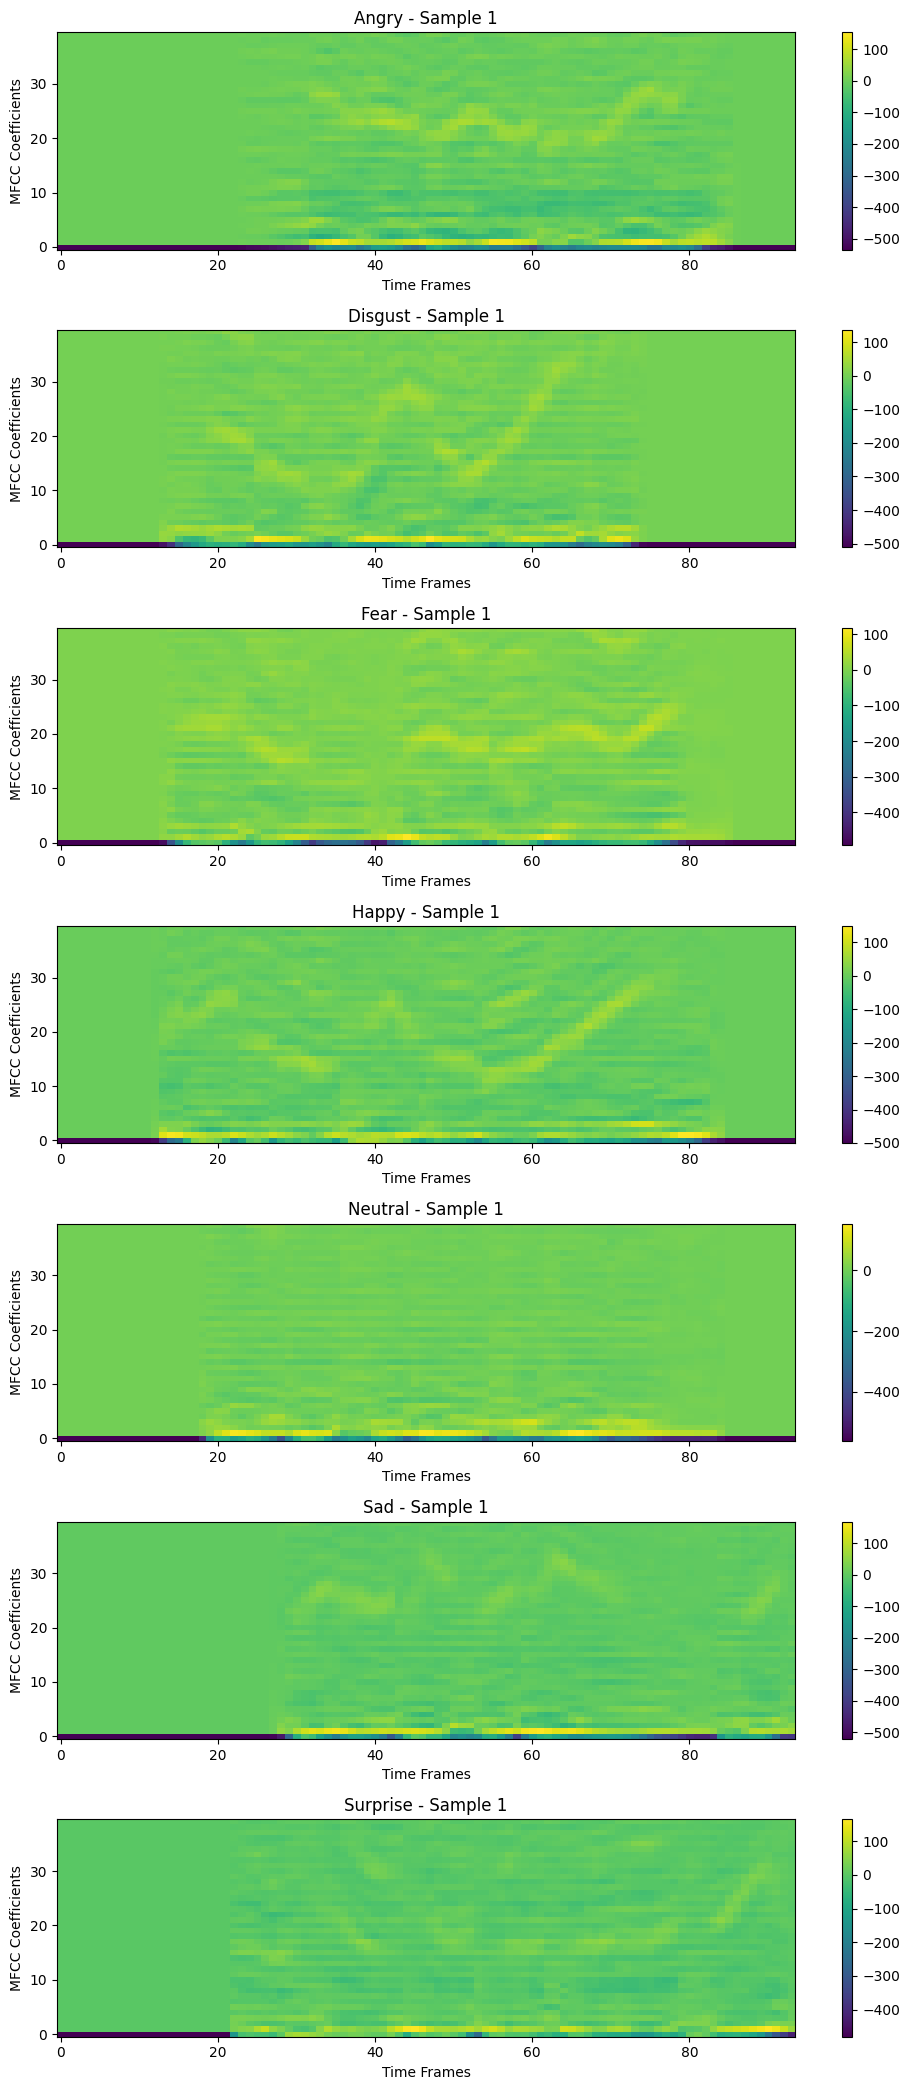

In [5]:
def visualize_mfcc_samples(features, labels, le, samples_per_emotion=1):
    """
    Visualize MFCC samples for each emotion.
    
    Args:
        features: Array of MFCC features (num_samples, max_len, n_mfcc)
        labels: Array of encoded labels
        le: LabelEncoder for emotion names
        samples_per_emotion: Number of samples to show per emotion
    """
    emotions = le.classes_
    num_emotions = len(emotions)
    
    # Create a grid of subplots
    if samples_per_emotion == 1:
        # Create a 1D array of subplots for single samples
        fig, axes = plt.subplots(num_emotions, 1, figsize=(10, 3 * num_emotions))
        # Ensure axes is always 2D for consistent indexing
        if num_emotions == 1:
            axes = np.array([axes])
    else:
        # Create a 2D grid for multiple samples
        fig, axes = plt.subplots(num_emotions, samples_per_emotion, 
                                figsize=(15, 3 * num_emotions))
    
    for i, emotion in enumerate(emotions):
        # Get indices of samples for this emotion
        emotion_indices = np.where(labels == i)[0]
        
        # Select random samples
        selected_indices = np.random.choice(emotion_indices, 
                                          size=min(samples_per_emotion, len(emotion_indices)), 
                                          replace=False)
        
        for j, idx in enumerate(selected_indices):
            # Get MFCC for this sample
            mfcc = features[idx]
            
            # Plot MFCC
            if samples_per_emotion == 1:
                ax = axes[i]  # 1D indexing
            else:
                ax = axes[i, j]  # 2D indexing
                
            im = ax.imshow(mfcc.T, cmap='viridis', aspect='auto', origin='lower')
            ax.set_title(f'{emotion} - Sample {j+1}')
            ax.set_xlabel('Time Frames')
            ax.set_ylabel('MFCC Coefficients')
            fig.colorbar(im, ax=ax)
    
    plt.tight_layout()
    plt.savefig('mfcc_samples.png')
    plt.show()

# After loading data, add this call:
print("\nVisualizing MFCC samples for each emotion...")
visualize_mfcc_samples(features, labels, le, samples_per_emotion=1)

Training model...


Epoch 1/50: 100%|██████████| 232/232 [00:01<00:00, 120.05it/s]


Epoch [1/50], Train Loss: 1.7574, Train Acc: 25.14%, Val Loss: 1.6362, Val Acc: 31.43%


Epoch 2/50: 100%|██████████| 232/232 [00:01<00:00, 121.49it/s]


Epoch [2/50], Train Loss: 1.6254, Train Acc: 30.48%, Val Loss: 1.5408, Val Acc: 34.13%


Epoch 3/50: 100%|██████████| 232/232 [00:01<00:00, 122.21it/s]


Epoch [3/50], Train Loss: 1.5214, Train Acc: 38.42%, Val Loss: 1.3842, Val Acc: 41.04%


Epoch 4/50: 100%|██████████| 232/232 [00:01<00:00, 117.06it/s]


Epoch [4/50], Train Loss: 1.4187, Train Acc: 44.61%, Val Loss: 1.4199, Val Acc: 40.93%


Epoch 5/50: 100%|██████████| 232/232 [00:02<00:00, 113.14it/s]


Epoch [5/50], Train Loss: 1.3442, Train Acc: 47.63%, Val Loss: 1.3040, Val Acc: 48.49%


Epoch 6/50: 100%|██████████| 232/232 [00:01<00:00, 122.38it/s]


Epoch [6/50], Train Loss: 1.2857, Train Acc: 49.68%, Val Loss: 1.1800, Val Acc: 54.75%


Epoch 7/50: 100%|██████████| 232/232 [00:01<00:00, 126.25it/s]


Epoch [7/50], Train Loss: 1.2043, Train Acc: 52.68%, Val Loss: 1.1497, Val Acc: 54.86%


Epoch 8/50: 100%|██████████| 232/232 [00:01<00:00, 124.81it/s]


Epoch [8/50], Train Loss: 1.1380, Train Acc: 55.10%, Val Loss: 1.0403, Val Acc: 57.99%


Epoch 9/50: 100%|██████████| 232/232 [00:01<00:00, 129.72it/s]


Epoch [9/50], Train Loss: 1.0906, Train Acc: 57.53%, Val Loss: 1.0278, Val Acc: 57.56%


Epoch 10/50: 100%|██████████| 232/232 [00:01<00:00, 137.28it/s]


Epoch [10/50], Train Loss: 1.0359, Train Acc: 60.13%, Val Loss: 0.9313, Val Acc: 63.82%


Epoch 11/50: 100%|██████████| 232/232 [00:01<00:00, 131.93it/s]


Epoch [11/50], Train Loss: 0.9561, Train Acc: 62.82%, Val Loss: 0.9207, Val Acc: 62.10%


Epoch 12/50: 100%|██████████| 232/232 [00:01<00:00, 136.66it/s]


Epoch [12/50], Train Loss: 0.9362, Train Acc: 63.89%, Val Loss: 0.8744, Val Acc: 67.06%


Epoch 13/50: 100%|██████████| 232/232 [00:01<00:00, 126.13it/s]


Epoch [13/50], Train Loss: 0.8842, Train Acc: 65.44%, Val Loss: 0.8159, Val Acc: 67.06%


Epoch 14/50: 100%|██████████| 232/232 [00:01<00:00, 134.72it/s]


Epoch [14/50], Train Loss: 0.8381, Train Acc: 68.14%, Val Loss: 0.8220, Val Acc: 68.14%


Epoch 15/50: 100%|██████████| 232/232 [00:01<00:00, 131.65it/s]


Epoch [15/50], Train Loss: 0.7994, Train Acc: 69.31%, Val Loss: 0.7619, Val Acc: 69.87%


Epoch 16/50: 100%|██████████| 232/232 [00:01<00:00, 120.39it/s]


Epoch [16/50], Train Loss: 0.7616, Train Acc: 71.38%, Val Loss: 0.8385, Val Acc: 68.79%


Epoch 17/50: 100%|██████████| 232/232 [00:02<00:00, 113.25it/s]


Epoch [17/50], Train Loss: 0.7241, Train Acc: 72.28%, Val Loss: 0.7657, Val Acc: 70.63%


Epoch 18/50: 100%|██████████| 232/232 [00:02<00:00, 113.47it/s]


Epoch [18/50], Train Loss: 0.6737, Train Acc: 74.40%, Val Loss: 0.7042, Val Acc: 73.11%


Epoch 19/50: 100%|██████████| 232/232 [00:02<00:00, 109.69it/s]


Epoch [19/50], Train Loss: 0.6670, Train Acc: 74.92%, Val Loss: 0.7099, Val Acc: 74.51%


Epoch 20/50: 100%|██████████| 232/232 [00:01<00:00, 116.52it/s]


Epoch [20/50], Train Loss: 0.6251, Train Acc: 76.86%, Val Loss: 0.6780, Val Acc: 74.51%


Epoch 21/50: 100%|██████████| 232/232 [00:01<00:00, 117.90it/s]


Epoch [21/50], Train Loss: 0.5982, Train Acc: 78.07%, Val Loss: 0.6611, Val Acc: 75.49%


Epoch 22/50: 100%|██████████| 232/232 [00:01<00:00, 120.58it/s]


Epoch [22/50], Train Loss: 0.5728, Train Acc: 79.11%, Val Loss: 0.6265, Val Acc: 78.19%


Epoch 23/50: 100%|██████████| 232/232 [00:01<00:00, 116.45it/s]


Epoch [23/50], Train Loss: 0.5567, Train Acc: 79.53%, Val Loss: 0.6065, Val Acc: 78.29%


Epoch 24/50: 100%|██████████| 232/232 [00:01<00:00, 122.51it/s]


Epoch [24/50], Train Loss: 0.5160, Train Acc: 81.33%, Val Loss: 0.6566, Val Acc: 77.65%


Epoch 25/50: 100%|██████████| 232/232 [00:01<00:00, 121.08it/s]


Epoch [25/50], Train Loss: 0.4878, Train Acc: 82.22%, Val Loss: 0.5851, Val Acc: 79.37%


Epoch 26/50: 100%|██████████| 232/232 [00:01<00:00, 121.72it/s]


Epoch [26/50], Train Loss: 0.4626, Train Acc: 83.14%, Val Loss: 0.6105, Val Acc: 76.67%


Epoch 27/50: 100%|██████████| 232/232 [00:01<00:00, 120.66it/s]


Epoch [27/50], Train Loss: 0.4483, Train Acc: 83.73%, Val Loss: 0.6298, Val Acc: 78.73%


Epoch 28/50: 100%|██████████| 232/232 [00:01<00:00, 127.33it/s]


Epoch [28/50], Train Loss: 0.4078, Train Acc: 85.03%, Val Loss: 0.6089, Val Acc: 79.27%


Epoch 29/50: 100%|██████████| 232/232 [00:01<00:00, 136.57it/s]


Epoch [29/50], Train Loss: 0.4232, Train Acc: 84.89%, Val Loss: 0.5951, Val Acc: 80.02%


Epoch 30/50: 100%|██████████| 232/232 [00:01<00:00, 142.09it/s]


Epoch [30/50], Train Loss: 0.3943, Train Acc: 85.55%, Val Loss: 0.6102, Val Acc: 80.67%


Epoch 31/50: 100%|██████████| 232/232 [00:01<00:00, 138.62it/s]


Epoch [31/50], Train Loss: 0.3707, Train Acc: 86.80%, Val Loss: 0.5769, Val Acc: 81.32%


Epoch 32/50: 100%|██████████| 232/232 [00:01<00:00, 138.57it/s]


Epoch [32/50], Train Loss: 0.3665, Train Acc: 86.77%, Val Loss: 0.5910, Val Acc: 80.13%


Epoch 33/50: 100%|██████████| 232/232 [00:01<00:00, 131.16it/s]


Epoch [33/50], Train Loss: 0.3531, Train Acc: 87.53%, Val Loss: 0.5239, Val Acc: 82.94%


Epoch 34/50: 100%|██████████| 232/232 [00:01<00:00, 139.90it/s]


Epoch [34/50], Train Loss: 0.3483, Train Acc: 87.61%, Val Loss: 0.5628, Val Acc: 81.10%


Epoch 35/50: 100%|██████████| 232/232 [00:01<00:00, 134.68it/s]


Epoch [35/50], Train Loss: 0.3210, Train Acc: 88.78%, Val Loss: 0.6039, Val Acc: 80.35%


Epoch 36/50: 100%|██████████| 232/232 [00:01<00:00, 130.50it/s]


Epoch [36/50], Train Loss: 0.3237, Train Acc: 88.83%, Val Loss: 0.6341, Val Acc: 79.48%


Epoch 37/50: 100%|██████████| 232/232 [00:01<00:00, 133.43it/s]


Epoch [37/50], Train Loss: 0.3172, Train Acc: 88.74%, Val Loss: 0.5674, Val Acc: 82.29%


Epoch 38/50: 100%|██████████| 232/232 [00:01<00:00, 127.46it/s]


Epoch [38/50], Train Loss: 0.3097, Train Acc: 89.15%, Val Loss: 0.6330, Val Acc: 80.99%


Epoch 39/50: 100%|██████████| 232/232 [00:01<00:00, 120.76it/s]


Epoch [39/50], Train Loss: 0.2888, Train Acc: 89.86%, Val Loss: 0.6085, Val Acc: 80.35%


Epoch 40/50: 100%|██████████| 232/232 [00:01<00:00, 120.90it/s]


Epoch [40/50], Train Loss: 0.2789, Train Acc: 90.02%, Val Loss: 0.5761, Val Acc: 81.10%


Epoch 41/50: 100%|██████████| 232/232 [00:01<00:00, 117.41it/s]


Epoch [41/50], Train Loss: 0.2433, Train Acc: 91.27%, Val Loss: 0.6212, Val Acc: 81.43%


Epoch 42/50: 100%|██████████| 232/232 [00:01<00:00, 124.84it/s]


Epoch [42/50], Train Loss: 0.2719, Train Acc: 90.66%, Val Loss: 0.6272, Val Acc: 81.53%


Epoch 43/50: 100%|██████████| 232/232 [00:01<00:00, 122.64it/s]


Epoch [43/50], Train Loss: 0.2531, Train Acc: 91.33%, Val Loss: 0.5330, Val Acc: 84.02%


Epoch 44/50: 100%|██████████| 232/232 [00:01<00:00, 122.30it/s]


Epoch [44/50], Train Loss: 0.2370, Train Acc: 91.51%, Val Loss: 0.5841, Val Acc: 80.67%


Epoch 45/50: 100%|██████████| 232/232 [00:01<00:00, 121.65it/s]


Epoch [45/50], Train Loss: 0.2327, Train Acc: 92.33%, Val Loss: 0.5292, Val Acc: 84.67%


Epoch 46/50: 100%|██████████| 232/232 [00:01<00:00, 129.34it/s]


Epoch [46/50], Train Loss: 0.2273, Train Acc: 92.47%, Val Loss: 0.6504, Val Acc: 82.83%


Epoch 47/50: 100%|██████████| 232/232 [00:01<00:00, 132.05it/s]


Epoch [47/50], Train Loss: 0.2437, Train Acc: 91.76%, Val Loss: 0.5306, Val Acc: 83.69%


Epoch 48/50: 100%|██████████| 232/232 [00:01<00:00, 129.51it/s]


Epoch [48/50], Train Loss: 0.2340, Train Acc: 92.40%, Val Loss: 0.5979, Val Acc: 82.61%


Epoch 49/50: 100%|██████████| 232/232 [00:01<00:00, 132.79it/s]


Epoch [49/50], Train Loss: 0.2121, Train Acc: 92.93%, Val Loss: 0.5914, Val Acc: 82.61%


Epoch 50/50: 100%|██████████| 232/232 [00:01<00:00, 137.86it/s]


Epoch [50/50], Train Loss: 0.2239, Train Acc: 92.72%, Val Loss: 0.6120, Val Acc: 83.59%
Model saved to bangla_emotion_model.pth


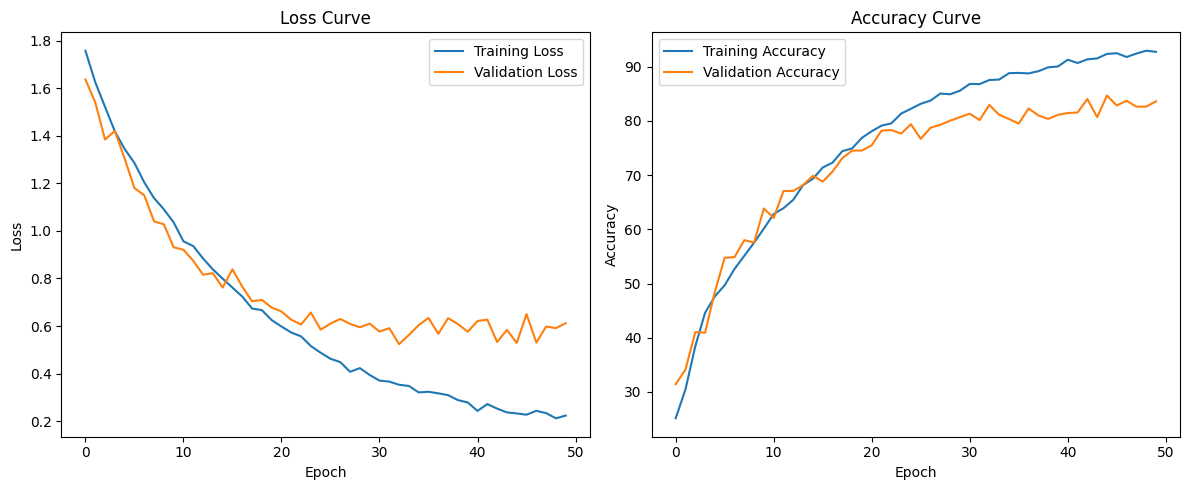


Evaluating on test set...
Test Accuracy: 82.18%


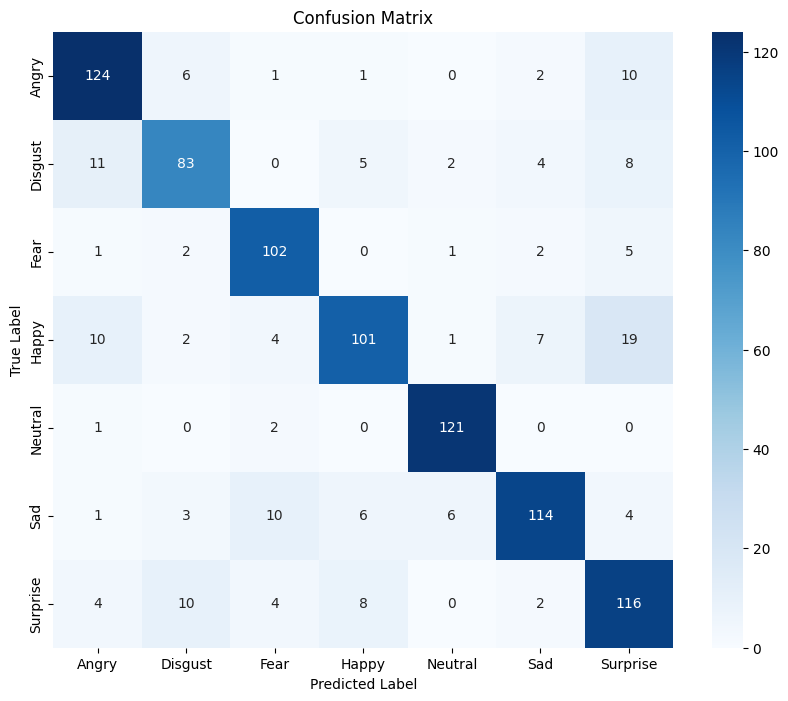


Classification Report:
              precision    recall  f1-score   support

       Angry       0.82      0.86      0.84       144
     Disgust       0.78      0.73      0.76       113
        Fear       0.83      0.90      0.86       113
       Happy       0.83      0.70      0.76       144
     Neutral       0.92      0.98      0.95       124
         Sad       0.87      0.79      0.83       144
    Surprise       0.72      0.81      0.76       144

    accuracy                           0.82       926
   macro avg       0.82      0.82      0.82       926
weighted avg       0.82      0.82      0.82       926



In [7]:
# model = EmotionModel(input_size, hidden_size, num_layers, num_classes).to(device)

# # Loss and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# # Training with validation
# print("Training model...")
# train_losses = []
# val_losses = []
# train_accs = []
# val_accs = []

# for epoch in range(70):
#     # Training phase
#     model.train()
#     train_loss = 0.0
#     correct = 0
#     total = 0
    
#     for features, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
#         features = features.to(device)
#         labels = labels.to(device)
        
#         optimizer.zero_grad()
#         outputs = model(features)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
        
#         train_loss += loss.item()
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
    
#     train_loss /= len(train_loader)
#     train_acc = 100 * correct / total
#     train_losses.append(train_loss)
#     train_accs.append(train_acc)
    
#     # Validation phase
#     model.eval()
#     val_loss = 0.0
#     correct = 0
#     total = 0
    
#     with torch.no_grad():
#         for features, labels in test_loader:
#             features = features.to(device)
#             labels = labels.to(device)
            
#             outputs = model(features)
#             loss = criterion(outputs, labels)
            
#             val_loss += loss.item()
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
    
#     val_loss /= len(test_loader)
#     val_acc = 100 * correct / total
#     val_losses.append(val_loss)
#     val_accs.append(val_acc)
    
#     print(f"Epoch [{epoch+1}/{EPOCHS}], "
#             f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
#             f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

# # Save model
# torch.save(model.state_dict(), MODEL_PATH)
# print(f"Model saved to {MODEL_PATH}")

# # Plot training history
# plot_training_history(train_losses, val_losses, train_accs, val_accs)

# # Evaluate and plot confusion matrix
# model.eval()
# y_true = []
# y_pred = []

# with torch.no_grad():
#     for features, labels in test_loader:
#         features = features.to(device)
#         labels = labels.to(device)
        
#         outputs = model(features)
#         _, predicted = torch.max(outputs, 1)
        
#         y_true.extend(labels.cpu().numpy())
#         y_pred.extend(predicted.cpu().numpy())

# plot_confusion_matrix(y_true, y_pred, le.classes_)

model = EmotionModel(input_size, hidden_size, num_layers, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training with validation
print("Training model...")
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(50):
    # Training phase
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for features, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        features = features.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss /= len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validation phase (using validation set)
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for features, labels in val_loader:  # Changed from test_loader to val_loader
            features = features.to(device)
            labels = labels.to(device)
            
            outputs = model(features)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss /= len(val_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"Epoch [{epoch+1}/{EPOCHS}], "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

# Save model
torch.save(model.state_dict(), MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

# Plot training history
plot_training_history(train_losses, val_losses, train_accs, val_accs)

# Final evaluation on TEST set (unseen during training)
print("\nEvaluating on test set...")
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for features, labels in test_loader:  # Using test_loader for final evaluation
        features = features.to(device)
        labels = labels.to(device)
        
        outputs = model(features)
        _, predicted = torch.max(outputs, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate test accuracy
test_acc = 100 * sum(np.array(y_true) == np.array(y_pred)) / len(y_true)
print(f"Test Accuracy: {test_acc:.2f}%")

# Plot confusion matrix for test set
plot_confusion_matrix(y_true, y_pred, le.classes_)

# # Start real-time recognition
# print("\nStarting real-time emotion recognition...")
# processor = AudioProcessor(model, le, device)
# processor.start()

In [8]:
# Start real-time recognition
print("\nStarting real-time emotion recognition...")
processor = AudioProcessor(model, le, device)
processor.start()


Starting real-time emotion recognition...
Listening... Press Ctrl+C to stop
Detected Emotion: Fear (1.00)
Detected Emotion: Fear (1.00)
Detected Emotion: Surprise (0.87)
Detected Emotion: Fear (0.92)
Detected Emotion: Fear (0.58)
Detected Emotion: Disgust (0.52)
Detected Emotion: Sad (0.98)
Detected Emotion: Fear (1.00)
Detected Emotion: Fear (1.00)
Detected Emotion: Disgust (0.49)
Detected Emotion: Surprise (1.00)
Detected Emotion: Fear (0.96)
Detected Emotion: Fear (0.95)
Detected Emotion: Angry (0.52)
Detected Emotion: Angry (0.73)
Detected Emotion: Disgust (0.91)
Detected Emotion: Angry (0.82)
Detected Emotion: Disgust (0.97)
Detected Emotion: Disgust (1.00)
Detected Emotion: Fear (1.00)
Detected Emotion: Sad (0.99)
Detected Emotion: Sad (0.97)
Detected Emotion: Angry (0.94)
Detected Emotion: Neutral (0.56)
Detected Emotion: Fear (0.57)
Detected Emotion: Disgust (0.48)
Detected Emotion: Sad (0.59)
Detected Emotion: Sad (0.94)
Detected Emotion: Fear (0.67)
Detected Emotion: Disgust